# all_in_one

In [4]:
import selenium 
selenium.__version__

'4.2.0'

In [5]:
# Libraries 
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import time
import re
import requests
import random
import pickle
import openpyxl
from konlpy.tag import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

In [6]:
#Queue의 기본적인 기능 구현
class Queue():
    def __init__(self, maxsize):
        self.queue = []
        self.maxsize = maxsize
        
    # Queue에 Data 넣음
    def enqueue(self, data):
        self.queue.append(data)

    # Queue에 가장 먼저 들어온 Data 내보냄
    def dequeue(self):
        dequeue_object = None
        if self.isEmpty():
            print("Queue is Empty")
        else:
            dequeue_object = self.queue[0]
            self.queue = self.queue[1:]
        return dequeue_object
    
    # Queue에 가장 먼저들어온 Data return
    def peek(self):
        peek_object = None
        if self.isEmpty():
            print("Queue is Empty")
        else:
            peek_object = self.queue[0]
        return peek_object
    
    # Queue가 비어있는지 확인
    def isEmpty(self):
        is_empty = False
        if len(self.queue) == 0:
            is_empty = True
        return is_empty
    
    # Queue의 Size가 Max Size를 초과하는지 확인
    def isMaxSizeOver(self):
        queue_size = len(self.queue)
        if (queue_size > self.maxsize):
            return False
        else :
            return True

In [43]:
def scraping(url):
    """
    url = 관련 데이터를 스크래핑 해 올 유튜브 동영상 링크 하나 
    """
    if __name__=="__main__":
        #set option of selenium
        options = webdriver.ChromeOptions()
        options.add_argument('window-size=1920x1080')
        options.add_argument('disable-gpu')
        options.add_argument('headless') # 크롬 띄우는 창 없애기
        options.add_argument('user')
        options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36")
        options.add_argument("lang=ko_KR")
        driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)

        #target of crawling
        data_list = []
        driver.get(url)
        
        #페이지 Open 후 기다리는 시간
        time.sleep(5.0)

        #초기 댓글 보이게 창 내려보기 
        driver.execute_script("window.scrollTo(0,300)")

        time.sleep(5.0)

        #down the scroll
        body = driver.find_element_by_tag_name('body')
        last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        


        # max size 50의 Queue 생성
        # 0.1sec * 50 = 5sec 동안 Scroll 업데이트가 없으면 스크롤 내리기 종료
        szQ = Queue(100)
        enqueue_count = 0
        
        while True:
            # Scroll 내리기
            driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
            
            # Scroll Height를 가져오는 주기
            time.sleep(0.1)
            new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
            
            # Queue가 꽉 차는 경우 스크롤 내리기 종료
            if(enqueue_count > szQ.maxsize):
                break
            
            # 첫 Loop 수행 (Queue가 비어있는 경우) 예외 처리
            if(szQ.isEmpty()) :
                szQ.enqueue(new_page_height)
                enqueue_count += 1
                
            # Queue에 가장 먼저 들어온 데이터와 새로 업데이트 된 Scroll Height를 비교함
            # 같으면 그대로 Enqueue, 다르면 Queue의 모든 Data를 Dequeue 후 새로운 Scroll Height를 Enqueue 함.    
            else :
                if(szQ.peek() == new_page_height) :
                    szQ.enqueue(new_page_height)
                    enqueue_count += 1
                else :
                    szQ.enqueue(new_page_height)
                    for z in range(enqueue_count) :
                        szQ.dequeue()
                    enqueue_count = 1
            
            # 기존의 Scroll 내리는 방식      
            #if new_page_height == last_page_height:
            #    break
            #last_page_height = new_page_height
            #time.sleep(2.0)
        
        # print ("[PASS] Get all comments of URL")

        html0 = driver.page_source
        # driver.close()
        html = BeautifulSoup(html0, 'html.parser')

        comments_list = html.findAll('ytd-comment-thread-renderer', {'class':'style-scope ytd-item-section-renderer'})
        # print (comments_list)
        ## 재생목록이름
        
    # list_name = comments_list[j].find('a', {'class': 'yt-simple-endpoint style-scope yt-formatted-string'}).text
    list_name = driver.find_element_by_css_selector('#header-description > h3:nth-child(1) > yt-formatted-string > a').text

    ## 전체 조회수
    # views = comments_list[j].find('span', {'class': 'view-count style-scope ytd-video-view-count-renderer'}).text
    # views = driver.find_element_by_css_selector('#count > ytd-video-view-count-renderer > span.view-count.style-scope.ytd-video-view-count-renderer').text

    # css selector 수정 0704
    views = driver.find_element_by_css_selector('#count > ytd-video-view-count-renderer > span.view-count.style-scope.ytd-video-view-count-renderer').text 
    
    ## 제목 
    # name = comments_list[j].find('yt-formatted-string', {'class': 'style-scope ytd-video-primary-info-renderer'}).text
    # name = driver.find_element_by_css_selector('#container > h1 > yt-formatted-string').text

    # css selector 수정 0704
    name = driver.find_element_by_css_selector('#container > h1 > yt-formatted-string').text

    for j in range(len(comments_list)):
        ## 댓글 내용
        comment = comments_list[j].find('yt-formatted-string', {'id': 'content-text'}).text
        comment = comment.replace('\n', '') # 줄 바뀜 없애기
        comment = comment.replace('\t', '') # 탭 줄이기
        # print(comment)

        ##유튜브 댓글 id

        youtube_id = comments_list[j].find('a', {'id': 'author-text'}).span.text
        youtube_id = youtube_id.replace('\n', '') # 줄 바뀜 없애기
        youtube_id = youtube_id.replace('\t', '') # 탭 줄이기
        youtube_id = youtube_id.strip()

        ## 댓글 좋아요 개수 (0인 경우 예외 처리)
        try:
            like_num = comments_list[j].find('span',
                                        {'id': 'vote-count-middle',
                                        'class': 'style-scope ytd-comment-action-buttons-renderer',
                                        'aria-label': re.compile('좋아요')}).text
            like_num = like_num.replace('\n', '') # 줄 바뀜 없애기
            like_num = like_num.replace('\t', '') # 탭 줄이기
            like_num = like_num.strip()
        except:
            like_num = 0

        data = {'list_name': list_name, 'name': name, 'views': views, 'youtube_id': youtube_id, 'comment_ori': comment, 'like_num': like_num}
        data_list.append(data)

    result_df = pd.DataFrame(data_list,
                            columns=['list_name','name','views', 'youtube_id', 'comment_ori', 'like_num'])

    # result_df.to_excel(dir, index = False) #all_in_one 에서는 excel로 만들 필요 없음.
    driver.close()
    return result_df

In [ ]:
def emoticon_del(data):
    #이모티콘 제거
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,"a-zA-z0-9:;.\n\r#\ufeff\u200d]')

    comment_list = []
    for i in range(len(data)):
        comment_list.append(data['comment_ori'].iloc[i])

    comment_result = []
    for i in comment_list:
        tokens = re.sub(emoji_pattern,"",str(i))
        tokens = re.sub(han,"",tokens)
        comment_result.append(tokens)
    comment_result = pd.DataFrame(comment_result, columns=["comment_del"])
    data['comment_del'] = comment_result 

    return data

In [70]:
def tokenizer(data):
    # 불용어(포함 안 시킬 단어) 처리 
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', 
    '임', '게', '만', '게임', '겜', '되', '음', '면', '!', '.', ',', '~', '?', 'ㅡ', 'ㅠ', 'ㅜ']

    ##C드라이브 Mecab이 설치되어 있는 곳 -> dicpath로 넣어주어야함
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic") 
    
    data['tokenized'] = data['comment_del'].apply(mecab.morphs) #형태소 추출
    data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [10]:
def to_number(data):
    # views 수정
    data['views'] = data['views'].apply(lambda x: re.sub('[^0-9]', "", x)).astype(int)

    # like_num 수정
    def like_arrage(x):
        if type(x) == float or type(x) == int:
            return x 
        if '만' in x:
            if len(x) > 1:
                return float(x.replace('만','')) * 10000
            return x
        if '천' in x:
            if len(x) > 1:
                return float(x.replace('천','')) * 1000
        return x
    
    data['like_num'] = data['like_num'].apply(like_arrage).astype(int)

In [11]:
def del_for_cloud(data):
    # #이모티콘 제거
    # emoji_pattern = re.compile("["
    #     u"\U0001F600-\U0001F64F"  # emoticons
    #     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #     u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #                        "]+", flags=re.UNICODE)
    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,"a-zA-z0-9:.\n\r#\ufeff\u200d]')

    comment_list = []
    for i in range(len(data)):
        comment_list.append(data['comment_ori'].iloc[i])

    comment_result = []
    for i in comment_list:
        # tokens = re.sub(emoji_pattern,"",str(i))
        tokens = re.sub(han,"",str(i))
        comment_result.append(tokens)
    comment_result = pd.DataFrame(comment_result, columns=["comment_cloud"])
    data['comment_cloud'] = comment_result 

    return data

In [102]:
# 전체 코멘트를 하나의 리스트에 담기
comment_sum = []
def coluding(data):
    for i in range(len(data)):
        comment_sum.append(data['comment_cloud'].iloc[i])
    # 형태소 분석을 해주기 위해 컬럼을 하나의 문자열로 만들어주기 
    str_comment_sum = " ".join(comment_sum)
    # 전체 comment에서 형태소 단위로 분리 
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic") 
    morphs = mecab.morphs(str_comment_sum)
    # morphs 단어 길이가 2 이상만 
    words = [n for n in morphs if len(n) > 1]
    # words에서 단어의 개수에 맞춰서 카운팅 
    c = Counter(words)
    #워드크라우드로 보이게 하기 
    wc = WordCloud(font_path='malgun', width=400, height=400, scale=2.0, max_font_size=250)
    gen = wc.generate_from_frequencies(c)
    plt.figure()
    return plt.imshow(gen)

In [101]:
def all_in_one(url):
    data = scraping(url)
    data = emoticon_del(data)
    tokenizer(data)
    to_number(data)
    data = del_for_cloud(data)
    comment_sum = []
    cloudIMG = coluding(data)
    return data, cloudIMG

### TEST

In [111]:
test_data, test_IMG = all_in_one(test)

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 103.0.5060
[WDM] - Get LATEST chromedriver version for 103.0.5060 google-chrome
[WDM] - Driver [C:\Users\Huiseop\.wdm\drivers\chromedriver\win32\103.0.5060.53\chromedriver.exe] found in cache
C:\Users\Huiseop\AppData\Local\Temp\ipykernel_11372\2197495392.py:14: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
C:\Users\Huiseop\AppData\Local\Temp\ipykernel_11372\2197495392.py:14: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
C:\Users\Huiseop\AppData\Local\Temp\ipykernel_11372\2197495392.py:29: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  body = driver.find_element_by_tag_name('body')
C:\Users\Huiseop\AppData\Local\

ValueError: invalid literal for int() with base 10: ''

In [113]:
test_data

NameError: name 'test_data' is not defined

In [44]:
test = 'https://www.youtube.com/watch?v=CDSCozPkSvk&list=PLIHkbyUJLOS8oPA8VDBiPiYv1vbhYsLCb&ab_channel=%EB%86%80%EB%A9%B4%EB%AD%90%ED%95%98%EB%8B%88%3F'
data = scraping(test)

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 103.0.5060
[WDM] - Get LATEST chromedriver version for 103.0.5060 google-chrome
[WDM] - Driver [C:\Users\Huiseop\.wdm\drivers\chromedriver\win32\103.0.5060.53\chromedriver.exe] found in cache
C:\Users\Huiseop\AppData\Local\Temp\ipykernel_11372\2197495392.py:14: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
C:\Users\Huiseop\AppData\Local\Temp\ipykernel_11372\2197495392.py:14: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
C:\Users\Huiseop\AppData\Local\Temp\ipykernel_11372\2197495392.py:29: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  body = driver.find_element_by_tag_name('body')
C:\Users\Huiseop\AppData\Local\

In [82]:
data

,list_name,name,views,youtube_id,comment_ori,like_num,comment_del,tokenized
0,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,thanks for coming.,"ㅁ허헐,, 무한상사에 진심인 나,,재즈 대신 무한상사 틀어놓고 자는데,,",1500,허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데,"[허, 헐, 무한, 상사, 진심, 나, 재즈, 대신, 무한, 상사, 틀, 어, 놓,..."
1,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,taetae love love,정준하님 보고 울뻔...ㅠㅜ이번 기회에 다시 다 모이면 안될까요?명수님 형돈님 하하...,6,정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...,"[정준하, 님, 보, 울, 뻔, 이번, 기회, 다시, 모이, 안, 될까요, 명수, ..."
2,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,이진현,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음..그...,41,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...,"[진짜, 에피소드, 실패, 든, 성공, 든, 이렇게, 여러, 개, 도전, 해, 보,..."
3,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,신영웅,진짜 김태호PD의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 ㅎ ...,446,진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...,"[진짜, 김태호, 제작, 력, 이란, ;;;, 참, 스펙트럼, 넓, 정말, 포인트,..."
4,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,쏘토닉,와....예능으로 이렇게 엄청난 구성이 가능하구나. 진짜 대단하다 존경을 넘어 경외...,155,와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦,"[와예, 능, 으로, 이렇게, 엄청난, 구성, 가능, 구나, 진짜, 대단, 존경, ..."
...,...,...,...,...,...,...,...,...
970,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,jw924 s,31초쯤 작게 들리는 목소리 하하 같은데,1,초쯤 작게 들리는 목소리 하하 같은데,"[초, 쯤, 작, 들리, 목소리, 하하, 같, 은데]"
971,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Paul Cho,박명수는 빼주세요,2,박명수는 빼주세요,"[박명수, 빼, 주, 세요]"
972,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,익공익미,5ㅇ29일 놀면뭐하니에 이용진은 왜 나옵니까?사람이 그리도 없나요? 방송에서 대통령...,0,일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...,"[일, 놀, 뭐, 하니에, 이용진, 왜, 나옵니까, 사람, 그리도, 없, 나요, 방..."
973,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Name No,무한상사? 맴버 모으고 찍는건가?,2,무한상사 맴버 모으고 찍는건가,"[무한, 상사, 맴, 버, 모으, 찍, 건가]"


In [83]:
data1 = data

In [84]:
data1

,list_name,name,views,youtube_id,comment_ori,like_num,comment_del,tokenized
0,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,thanks for coming.,"ㅁ허헐,, 무한상사에 진심인 나,,재즈 대신 무한상사 틀어놓고 자는데,,",1500,허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데,"[허, 헐, 무한, 상사, 진심, 나, 재즈, 대신, 무한, 상사, 틀, 어, 놓,..."
1,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,taetae love love,정준하님 보고 울뻔...ㅠㅜ이번 기회에 다시 다 모이면 안될까요?명수님 형돈님 하하...,6,정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...,"[정준하, 님, 보, 울, 뻔, 이번, 기회, 다시, 모이, 안, 될까요, 명수, ..."
2,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,이진현,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음..그...,41,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...,"[진짜, 에피소드, 실패, 든, 성공, 든, 이렇게, 여러, 개, 도전, 해, 보,..."
3,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,신영웅,진짜 김태호PD의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 ㅎ ...,446,진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...,"[진짜, 김태호, 제작, 력, 이란, ;;;, 참, 스펙트럼, 넓, 정말, 포인트,..."
4,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,쏘토닉,와....예능으로 이렇게 엄청난 구성이 가능하구나. 진짜 대단하다 존경을 넘어 경외...,155,와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦,"[와예, 능, 으로, 이렇게, 엄청난, 구성, 가능, 구나, 진짜, 대단, 존경, ..."
...,...,...,...,...,...,...,...,...
970,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,jw924 s,31초쯤 작게 들리는 목소리 하하 같은데,1,초쯤 작게 들리는 목소리 하하 같은데,"[초, 쯤, 작, 들리, 목소리, 하하, 같, 은데]"
971,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Paul Cho,박명수는 빼주세요,2,박명수는 빼주세요,"[박명수, 빼, 주, 세요]"
972,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,익공익미,5ㅇ29일 놀면뭐하니에 이용진은 왜 나옵니까?사람이 그리도 없나요? 방송에서 대통령...,0,일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...,"[일, 놀, 뭐, 하니에, 이용진, 왜, 나옵니까, 사람, 그리도, 없, 나요, 방..."
973,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Name No,무한상사? 맴버 모으고 찍는건가?,2,무한상사 맴버 모으고 찍는건가,"[무한, 상사, 맴, 버, 모으, 찍, 건가]"


In [85]:
data1 = emoticon_del(data1)

In [86]:
data1

,list_name,name,views,youtube_id,comment_ori,like_num,comment_del,tokenized
0,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,thanks for coming.,"ㅁ허헐,, 무한상사에 진심인 나,,재즈 대신 무한상사 틀어놓고 자는데,,",1500,허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데,"[허, 헐, 무한, 상사, 진심, 나, 재즈, 대신, 무한, 상사, 틀, 어, 놓,..."
1,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,taetae love love,정준하님 보고 울뻔...ㅠㅜ이번 기회에 다시 다 모이면 안될까요?명수님 형돈님 하하...,6,정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...,"[정준하, 님, 보, 울, 뻔, 이번, 기회, 다시, 모이, 안, 될까요, 명수, ..."
2,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,이진현,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음..그...,41,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...,"[진짜, 에피소드, 실패, 든, 성공, 든, 이렇게, 여러, 개, 도전, 해, 보,..."
3,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,신영웅,진짜 김태호PD의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 ㅎ ...,446,진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...,"[진짜, 김태호, 제작, 력, 이란, ;;;, 참, 스펙트럼, 넓, 정말, 포인트,..."
4,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,쏘토닉,와....예능으로 이렇게 엄청난 구성이 가능하구나. 진짜 대단하다 존경을 넘어 경외...,155,와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦,"[와예, 능, 으로, 이렇게, 엄청난, 구성, 가능, 구나, 진짜, 대단, 존경, ..."
...,...,...,...,...,...,...,...,...
970,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,jw924 s,31초쯤 작게 들리는 목소리 하하 같은데,1,초쯤 작게 들리는 목소리 하하 같은데,"[초, 쯤, 작, 들리, 목소리, 하하, 같, 은데]"
971,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Paul Cho,박명수는 빼주세요,2,박명수는 빼주세요,"[박명수, 빼, 주, 세요]"
972,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,익공익미,5ㅇ29일 놀면뭐하니에 이용진은 왜 나옵니까?사람이 그리도 없나요? 방송에서 대통령...,0,일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...,"[일, 놀, 뭐, 하니에, 이용진, 왜, 나옵니까, 사람, 그리도, 없, 나요, 방..."
973,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Name No,무한상사? 맴버 모으고 찍는건가?,2,무한상사 맴버 모으고 찍는건가,"[무한, 상사, 맴, 버, 모으, 찍, 건가]"


In [87]:
tokenizer(data1)

In [88]:
data1

,list_name,name,views,youtube_id,comment_ori,like_num,comment_del,tokenized
0,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,thanks for coming.,"ㅁ허헐,, 무한상사에 진심인 나,,재즈 대신 무한상사 틀어놓고 자는데,,",1500,허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데,"[허, 헐, 무한, 상사, 진심, 나, 재즈, 대신, 무한, 상사, 틀, 어, 놓,..."
1,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,taetae love love,정준하님 보고 울뻔...ㅠㅜ이번 기회에 다시 다 모이면 안될까요?명수님 형돈님 하하...,6,정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...,"[정준하, 님, 보, 울, 뻔, 이번, 기회, 다시, 모이, 안, 될까요, 명수, ..."
2,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,이진현,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음..그...,41,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...,"[진짜, 에피소드, 실패, 든, 성공, 든, 이렇게, 여러, 개, 도전, 해, 보,..."
3,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,신영웅,진짜 김태호PD의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 ㅎ ...,446,진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...,"[진짜, 김태호, 제작, 력, 이란, ;;;, 참, 스펙트럼, 넓, 정말, 포인트,..."
4,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,쏘토닉,와....예능으로 이렇게 엄청난 구성이 가능하구나. 진짜 대단하다 존경을 넘어 경외...,155,와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦,"[와예, 능, 으로, 이렇게, 엄청난, 구성, 가능, 구나, 진짜, 대단, 존경, ..."
...,...,...,...,...,...,...,...,...
970,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,jw924 s,31초쯤 작게 들리는 목소리 하하 같은데,1,초쯤 작게 들리는 목소리 하하 같은데,"[초, 쯤, 작, 들리, 목소리, 하하, 같, 은데]"
971,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Paul Cho,박명수는 빼주세요,2,박명수는 빼주세요,"[박명수, 빼, 주, 세요]"
972,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,익공익미,5ㅇ29일 놀면뭐하니에 이용진은 왜 나옵니까?사람이 그리도 없나요? 방송에서 대통령...,0,일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...,"[일, 놀, 뭐, 하니에, 이용진, 왜, 나옵니까, 사람, 그리도, 없, 나요, 방..."
973,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Name No,무한상사? 맴버 모으고 찍는건가?,2,무한상사 맴버 모으고 찍는건가,"[무한, 상사, 맴, 버, 모으, 찍, 건가]"


In [89]:
to_number(data1)

TypeError: expected string or bytes-like object

In [91]:
data1

,list_name,name,views,youtube_id,comment_ori,like_num,comment_del,tokenized
0,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,thanks for coming.,"ㅁ허헐,, 무한상사에 진심인 나,,재즈 대신 무한상사 틀어놓고 자는데,,",1500,허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데,"[허, 헐, 무한, 상사, 진심, 나, 재즈, 대신, 무한, 상사, 틀, 어, 놓,..."
1,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,taetae love love,정준하님 보고 울뻔...ㅠㅜ이번 기회에 다시 다 모이면 안될까요?명수님 형돈님 하하...,6,정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...,"[정준하, 님, 보, 울, 뻔, 이번, 기회, 다시, 모이, 안, 될까요, 명수, ..."
2,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,이진현,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음..그...,41,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...,"[진짜, 에피소드, 실패, 든, 성공, 든, 이렇게, 여러, 개, 도전, 해, 보,..."
3,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,신영웅,진짜 김태호PD의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 ㅎ ...,446,진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...,"[진짜, 김태호, 제작, 력, 이란, ;;;, 참, 스펙트럼, 넓, 정말, 포인트,..."
4,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,쏘토닉,와....예능으로 이렇게 엄청난 구성이 가능하구나. 진짜 대단하다 존경을 넘어 경외...,155,와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦,"[와예, 능, 으로, 이렇게, 엄청난, 구성, 가능, 구나, 진짜, 대단, 존경, ..."
...,...,...,...,...,...,...,...,...
970,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,jw924 s,31초쯤 작게 들리는 목소리 하하 같은데,1,초쯤 작게 들리는 목소리 하하 같은데,"[초, 쯤, 작, 들리, 목소리, 하하, 같, 은데]"
971,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Paul Cho,박명수는 빼주세요,2,박명수는 빼주세요,"[박명수, 빼, 주, 세요]"
972,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,익공익미,5ㅇ29일 놀면뭐하니에 이용진은 왜 나옵니까?사람이 그리도 없나요? 방송에서 대통령...,0,일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...,"[일, 놀, 뭐, 하니에, 이용진, 왜, 나옵니까, 사람, 그리도, 없, 나요, 방..."
973,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Name No,무한상사? 맴버 모으고 찍는건가?,2,무한상사 맴버 모으고 찍는건가,"[무한, 상사, 맴, 버, 모으, 찍, 건가]"


In [92]:
data1 = del_for_cloud(data1)

In [93]:
data1

,list_name,name,views,youtube_id,comment_ori,like_num,comment_del,tokenized,comment_cloud
0,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,thanks for coming.,"ㅁ허헐,, 무한상사에 진심인 나,,재즈 대신 무한상사 틀어놓고 자는데,,",1500,허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데,"[허, 헐, 무한, 상사, 진심, 나, 재즈, 대신, 무한, 상사, 틀, 어, 놓,...",허헐 무한상사에 진심인 나재즈 대신 무한상사 틀어놓고 자는데
1,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,taetae love love,정준하님 보고 울뻔...ㅠㅜ이번 기회에 다시 다 모이면 안될까요?명수님 형돈님 하하...,6,정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...,"[정준하, 님, 보, 울, 뻔, 이번, 기회, 다시, 모이, 안, 될까요, 명수, ...",정준하님 보고 울뻔이번 기회에 다시 다 모이면 안될까요명수님 형돈님 하하님 홍철님 ...
2,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,이진현,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음..그...,41,진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...,"[진짜, 에피소드, 실패, 든, 성공, 든, 이렇게, 여러, 개, 도전, 해, 보,...",진짜 에피소드가 실패하든 성공하든이렇게 여러개 도전해보는 예능은놀뭐뿐인것 같음그래서...
3,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,신영웅,진짜 김태호PD의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 ㅎ ...,446,진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...,"[진짜, 김태호, 제작, 력, 이란, ;;;, 참, 스펙트럼, 넓, 정말, 포인트,...",진짜 김태호의 제작력이란;;; 참 스펙트럼도 넓고 정말 포인트를 잘 잡는듯 이번에...
4,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,쏘토닉,와....예능으로 이렇게 엄청난 구성이 가능하구나. 진짜 대단하다 존경을 넘어 경외...,155,와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦,"[와예, 능, 으로, 이렇게, 엄청난, 구성, 가능, 구나, 진짜, 대단, 존경, ...",와예능으로 이렇게 엄청난 구성이 가능하구나 진짜 대단하다 존경을 넘어 경외감이 듦
...,...,...,...,...,...,...,...,...,...
970,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,jw924 s,31초쯤 작게 들리는 목소리 하하 같은데,1,초쯤 작게 들리는 목소리 하하 같은데,"[초, 쯤, 작, 들리, 목소리, 하하, 같, 은데]",초쯤 작게 들리는 목소리 하하 같은데
971,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Paul Cho,박명수는 빼주세요,2,박명수는 빼주세요,"[박명수, 빼, 주, 세요]",박명수는 빼주세요
972,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,익공익미,5ㅇ29일 놀면뭐하니에 이용진은 왜 나옵니까?사람이 그리도 없나요? 방송에서 대통령...,0,일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...,"[일, 놀, 뭐, 하니에, 이용진, 왜, 나옵니까, 사람, 그리도, 없, 나요, 방...",일 놀면뭐하니에 이용진은 왜 나옵니까사람이 그리도 없나요 방송에서 대통령님이 친구인...
973,💼유본부장💼,[놀면뭐하니? 예고] 바쁜 도심 속.. 유부장의 새로운 시작✨ MBC210529방송,600306,Name No,무한상사? 맴버 모으고 찍는건가?,2,무한상사 맴버 모으고 찍는건가,"[무한, 상사, 맴, 버, 모으, 찍, 건가]",무한상사 맴버 모으고 찍는건가


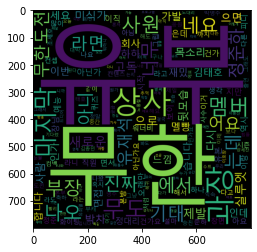

In [110]:
comment_sum = []
coluding(data)

In [109]:
print(cloudIMG)

AxesImage(112.68,36;217.44x217.44)


# comment_scraping

In [ ]:
pip install webdriver-manager
pip install openpyxl

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import time
import re
import requests
import random
import pickle
import openpyxl
from konlpy.tag import Mecab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

In [ ]:
#Queue의 기본적인 기능 구현
class Queue():
    def __init__(self, maxsize):
        self.queue = []
        self.maxsize = maxsize
        
    # Queue에 Data 넣음
    def enqueue(self, data):
        self.queue.append(data)

    # Queue에 가장 먼저 들어온 Data 내보냄
    def dequeue(self):
        dequeue_object = None
        if self.isEmpty():
            print("Queue is Empty")
        else:
            dequeue_object = self.queue[0]
            self.queue = self.queue[1:]
        return dequeue_object
    
    # Queue에 가장 먼저들어온 Data return
    def peek(self):
        peek_object = None
        if self.isEmpty():
            print("Queue is Empty")
        else:
            peek_object = self.queue[0]
        return peek_object
    
    # Queue가 비어있는지 확인
    def isEmpty(self):
        is_empty = False
        if len(self.queue) == 0:
            is_empty = True
        return is_empty
    
    # Queue의 Size가 Max Size를 초과하는지 확인
    def isMaxSizeOver(self):
        queue_size = len(self.queue)
        if (queue_size > self.maxsize):
            return False
        else :
            return True

In [ ]:
def scraping(url, dir):
    if __name__=="__main__":
        #set option of selenium
        options = webdriver.ChromeOptions()
        options.add_argument('window-size=1920x1080')
        options.add_argument('disable-gpu')
        options.add_argument('headless') # 크롬 띄우는 창 없애기
        options.add_argument('user')
        options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36")
        options.add_argument("lang=ko_KR")
        driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)

        #target of crawling
        data_list = []
        driver.get(url)
        
        #페이지 Open 후 기다리는 시간
        time.sleep(5.0)

        #초기 댓글 보이게 창 내려보기 
        driver.execute_script("window.scrollTo(0,300)")

        time.sleep(5.0)

        #down the scroll
        body = driver.find_element_by_tag_name('body')
        last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        


        # max size 50의 Queue 생성
        # 0.1sec * 50 = 5sec 동안 Scroll 업데이트가 없으면 스크롤 내리기 종료
        szQ = Queue(100)
        enqueue_count = 0
        
        while True:
            # Scroll 내리기
            driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
            
            # Scroll Height를 가져오는 주기
            time.sleep(0.1)
            new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
            
            # Queue가 꽉 차는 경우 스크롤 내리기 종료
            if(enqueue_count > szQ.maxsize):
                break
            
            # 첫 Loop 수행 (Queue가 비어있는 경우) 예외 처리
            if(szQ.isEmpty()) :
                szQ.enqueue(new_page_height)
                enqueue_count += 1
                
            # Queue에 가장 먼저 들어온 데이터와 새로 업데이트 된 Scroll Height를 비교함
            # 같으면 그대로 Enqueue, 다르면 Queue의 모든 Data를 Dequeue 후 새로운 Scroll Height를 Enqueue 함.    
            else :
                if(szQ.peek() == new_page_height) :
                    szQ.enqueue(new_page_height)
                    enqueue_count += 1
                else :
                    szQ.enqueue(new_page_height)
                    for z in range(enqueue_count) :
                        szQ.dequeue()
                    enqueue_count = 1
            
            # 기존의 Scroll 내리는 방식      
            #if new_page_height == last_page_height:
            #    break
            #last_page_height = new_page_height
            #time.sleep(2.0)
        
        # print ("[PASS] Get all comments of URL")

        html0 = driver.page_source
        # driver.close()
        html = BeautifulSoup(html0, 'html.parser')

        comments_list = html.findAll('ytd-comment-thread-renderer', {'class':'style-scope ytd-item-section-renderer'})
        # print (comments_list)
        ## 재생목록이름
        
    # list_name = comments_list[j].find('a', {'class': 'yt-simple-endpoint style-scope yt-formatted-string'}).text
    list_name = driver.find_element_by_css_selector('#header-description > h3:nth-child(1) > yt-formatted-string > a').text

    ## 전체 조회수
    # views = comments_list[j].find('span', {'class': 'view-count style-scope ytd-video-view-count-renderer'}).text
    views = driver.find_element_by_css_selector('#count > ytd-video-view-count-renderer > span.view-count.style-scope.ytd-video-view-count-renderer').text

    ## 제목 
    # name = comments_list[j].find('yt-formatted-string', {'class': 'style-scope ytd-video-primary-info-renderer'}).text
    name = driver.find_element_by_css_selector('#container > h1 > yt-formatted-string').text

    for j in range(len(comments_list)):
        ## 댓글 내용
        comment = comments_list[j].find('yt-formatted-string', {'id': 'content-text'}).text
        comment = comment.replace('\n', '') # 줄 바뀜 없애기
        comment = comment.replace('\t', '') # 탭 줄이기
        # print(comment)

        ##유튜브 댓글 id

        youtube_id = comments_list[j].find('a', {'id': 'author-text'}).span.text
        youtube_id = youtube_id.replace('\n', '') # 줄 바뀜 없애기
        youtube_id = youtube_id.replace('\t', '') # 탭 줄이기
        youtube_id = youtube_id.strip()

        ## 댓글 좋아요 개수 (0인 경우 예외 처리)
        try:
            like_num = comments_list[j].find('span',
                                        {'id': 'vote-count-middle',
                                        'class': 'style-scope ytd-comment-action-buttons-renderer',
                                        'aria-label': re.compile('좋아요')}).text
            like_num = like_num.replace('\n', '') # 줄 바뀜 없애기
            like_num = like_num.replace('\t', '') # 탭 줄이기
            like_num = like_num.strip()
        except:
            like_num = 0

        data = {'list_name': list_name, 'name': name, 'views': views, 'youtube_id': youtube_id, 'comment': comment, 'like_num': like_num}
        # data = {'comment': comment, 'like_num': like_num}
        data_list.append(data)
        # print(data)

    result_df = pd.DataFrame(data_list,
                            columns=['list_name','name','views', 'youtube_id', 'comment', 'like_num'])
    # result_df = pd.DataFrame(data_list,
                            #  columns=['comment', 'like_num'])
    result_df.to_excel(dir, index = False)
    driver.close()

# data_preprocessing

In [ ]:
pip install konlpy

## 데이터 로드 함수

In [ ]:
def load_data(path):
    """
    path = 'D:/AIB/CP1/여행계획.xlsx'
    """
    df = pd.DataFrame()
    data = pd.read_excel(path)
    return data

data = load_data('D:/AIB/CP1/벚꽃놀이.xlsx')

## 특수문자, 이모티콘 등 삭제 함수

In [ ]:
def emoticon_del(data):
    #이모티콘 제거
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,"a-zA-z0-9:.\n\r#\ufeff\u200d]')

    comment_list = []
    for i in range(len(data)):
        comment_list.append(data['comment'].iloc[i])

    comment_result = []
    for i in comment_list:
        tokens = re.sub(emoji_pattern,"",str(i))
        tokens = re.sub(han,"",tokens)
        comment_result.append(tokens)
    comment_result = pd.DataFrame(comment_result, columns=["comment"])
    data['comment'] = comment_result 

    return data


data = emoticon_del(data)

## 토큰화(수정 필요)

In [ ]:
def tokenizer(data):
    # 불용어(포함 안 시킬 단어) 처리 
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', 
    '임', '게', '만', '게임', '겜', '되', '음', '면', '!', '.', ',', '~', '?', 'ㅡ', 'ㅠ', 'ㅜ']

    ##C드라이브 Mecab이 설치되어 있는 곳 -> dicpath로 넣어주어야함
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic") 
    
    data['tokenized'] = data['comment'].apply(mecab.morphs) #형태소 추출
    data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

tokenizer(data)

## 조회수, 좋아요 -> 숫자만 남기게

In [ ]:
def to_number(data):
    # views 수정
    data['views'] = data['views'].apply(lambda x: re.sub('[^0-9]', "", x)).astype(int)

    # like_num 수정
    def like_arrage(x):
        if type(x) == float or type(x) == int:
            return x 
        if '만' in x:
            if len(x) > 1:
                return float(x.replace('만','')) * 10000
            return x
        if '천' in x:
            if len(x) > 1:
                return float(x.replace('천','')) * 1000
        return x
    
    data['like_num'] = data['like_num'].apply(like_arrage).astype(int)  

to_number(data)

# Word Cloud

In [ ]:
def load_data(path):
    """
    path = 'D:/AIB/CP1/여행계획.xlsx'
    """
    df = pd.DataFrame()
    data = pd.read_excel(path)
    return data

data = load_data('D:/AIB/CP1/벚꽃놀이.xlsx')

In [ ]:
def emoticon_del(data):
    # #이모티콘 제거
    # emoji_pattern = re.compile("["
    #     u"\U0001F600-\U0001F64F"  # emoticons
    #     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #     u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #                        "]+", flags=re.UNICODE)
    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,"a-zA-z0-9:.\n\r#\ufeff\u200d]')

    comment_list = []
    for i in range(len(data)):
        comment_list.append(data['comment'].iloc[i])

    comment_result = []
    for i in comment_list:
        # tokens = re.sub(emoji_pattern,"",str(i))
        tokens = re.sub(han,"",str(i))
        comment_result.append(tokens)
    comment_result = pd.DataFrame(comment_result, columns=["comment"])
    data['comment'] = comment_result 

    return data

In [ ]:
data = emoticon_del(data)

In [ ]:
def tokenizer(data):
    # 불용어(포함 안 시킬 단어) 처리 
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', 
    '임', '게', '만', '게임', '겜', '되', '음', '면', '!', '.', ',', '~', '?', 'ㅡ', 'ㅠ', 'ㅜ']

    ##C드라이브 Mecab이 설치되어 있는 곳 -> dicpath로 넣어주어야함
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic") 
    
    data['tokenized'] = data['comment'].apply(mecab.morphs) #형태소 추출
    data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [ ]:
tokenizer(data)
data

In [ ]:
# 전체 코멘트를 하나의 리스트에 담기
comment_sum = []
for i in range(len(data)):
    comment_sum.append(data['comment'].iloc[i])
# 형태소 분석을 해주기 위해 컬럼을 하나의 문자열로 만들어주기 
str_comment_sum = " ".join(comment_sum)
# 전체 comment에서 형태소 단위로 분리 
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic") 
morphs = mecab.morphs(str_comment_sum)
morphs
# morphs 단어 길이가 2 이상만 
words = [n for n in morphs if len(n) > 1]
# words에서 단어의 개수에 맞춰서 카운팅 
c = Counter(words)
#워드크라우드로 보이게 하기 
wc = WordCloud(font_path='malgun', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(c)
plt.figure()
plt.imshow(gen)